In [1]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [4]:
df = pd.read_csv('data/clean/clean_dataset_posStanza1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8061 entries, 0 to 8060
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          8061 non-null   object
 1   clean_name    8061 non-null   object
 2   name_length   8061 non-null   int64 
 3   noun_id       8061 non-null   object
 4   noun_en       8061 non-null   object
 5   noun_id_rm10  8061 non-null   object
 6   noun_id_rm20  8061 non-null   object
 7   noun_id_rm30  8061 non-null   object
 8   noun_id_rm40  8061 non-null   object
 9   noun_en_rm10  8061 non-null   object
 10  noun_en_rm20  8061 non-null   object
 11  noun_en_rm30  8061 non-null   object
 12  noun_en_rm40  8061 non-null   object
dtypes: int64(1), object(12)
memory usage: 818.8+ KB


In [5]:
# List min_df dan range klaster
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
vectorizers = {
    'basic preprocessing': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['clean_name']),
    'original en_noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_en']),
    'en_noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_en_rm10']),
    'en_noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_en_rm20']),
    'en_noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_en_rm30']),
    'en_noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_en_rm40']),
    'original id_noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_id']),
    'id_noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_id_rm10']),
    'id_noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_id_rm20']),
    'id_noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_id_rm30']),
    'id_noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['noun_id_rm40'])
}
results = []  # List untuk menyimpan hasil eksperimen

In [6]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(range_list, results):
    for name, data in vectorizers.items():
        print(f"Evaluating data={name}...")
        for cluster_range in range_list:
            silhouette_scores = []
            for n_clusters in cluster_range:
                # K-Means clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # Simpan hasil eksperimen
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# Jalankan eksperimen
clustering_experiment(range_list, results)

Evaluating data=basic preprocessing...
Evaluating data=original en_noun...
Evaluating data=en_noun remove-10...
Evaluating data=en_noun remove-20...
Evaluating data=en_noun remove-30...
Evaluating data=en_noun remove-40...
Evaluating data=original id_noun...
Evaluating data=id_noun remove-10...
Evaluating data=id_noun remove-20...
Evaluating data=id_noun remove-30...
Evaluating data=id_noun remove-40...


In [7]:
results_df = pd.DataFrame(results)

In [8]:
results_df.head()

model_noun cluster_range  avg_silhouette_score  \
0  basic preprocessing          2-19              0.005757   
1  basic preprocessing       100-119              0.020104   
2  basic preprocessing       500-519              0.034923   
3  basic preprocessing     1000-1019              0.048544   
4     original en_noun          2-19              0.007424   

   best_silhouette_score  
0               0.007826  
1               0.021472  
2               0.035594  
3               0.048680  
4               0.012365

C:\Users\User\AppData\Local\Temp\ipykernel_11924\3527163273.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


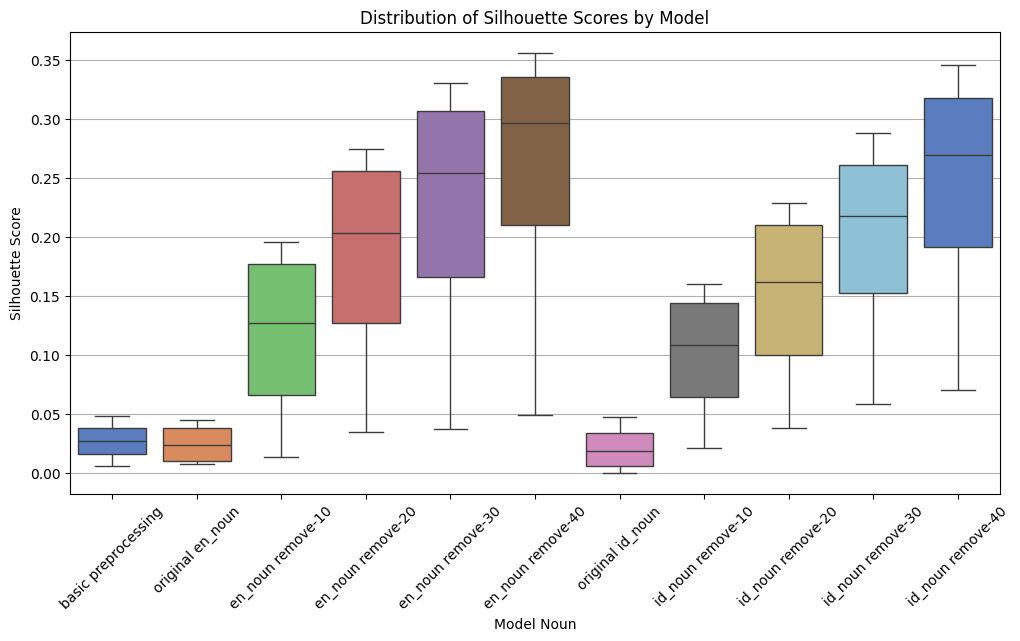

In [9]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


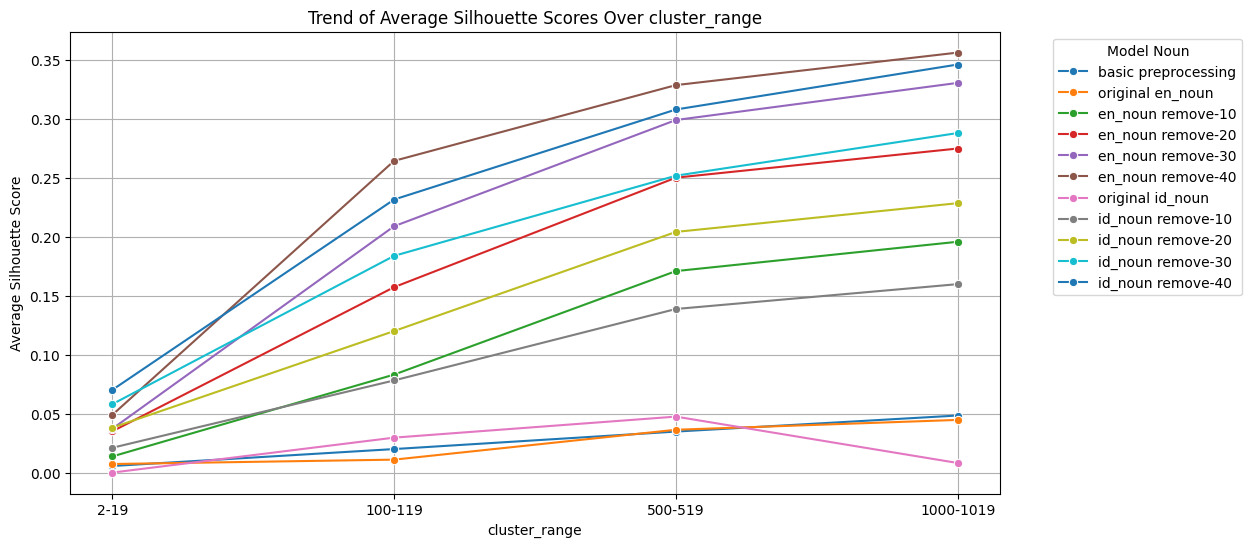

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


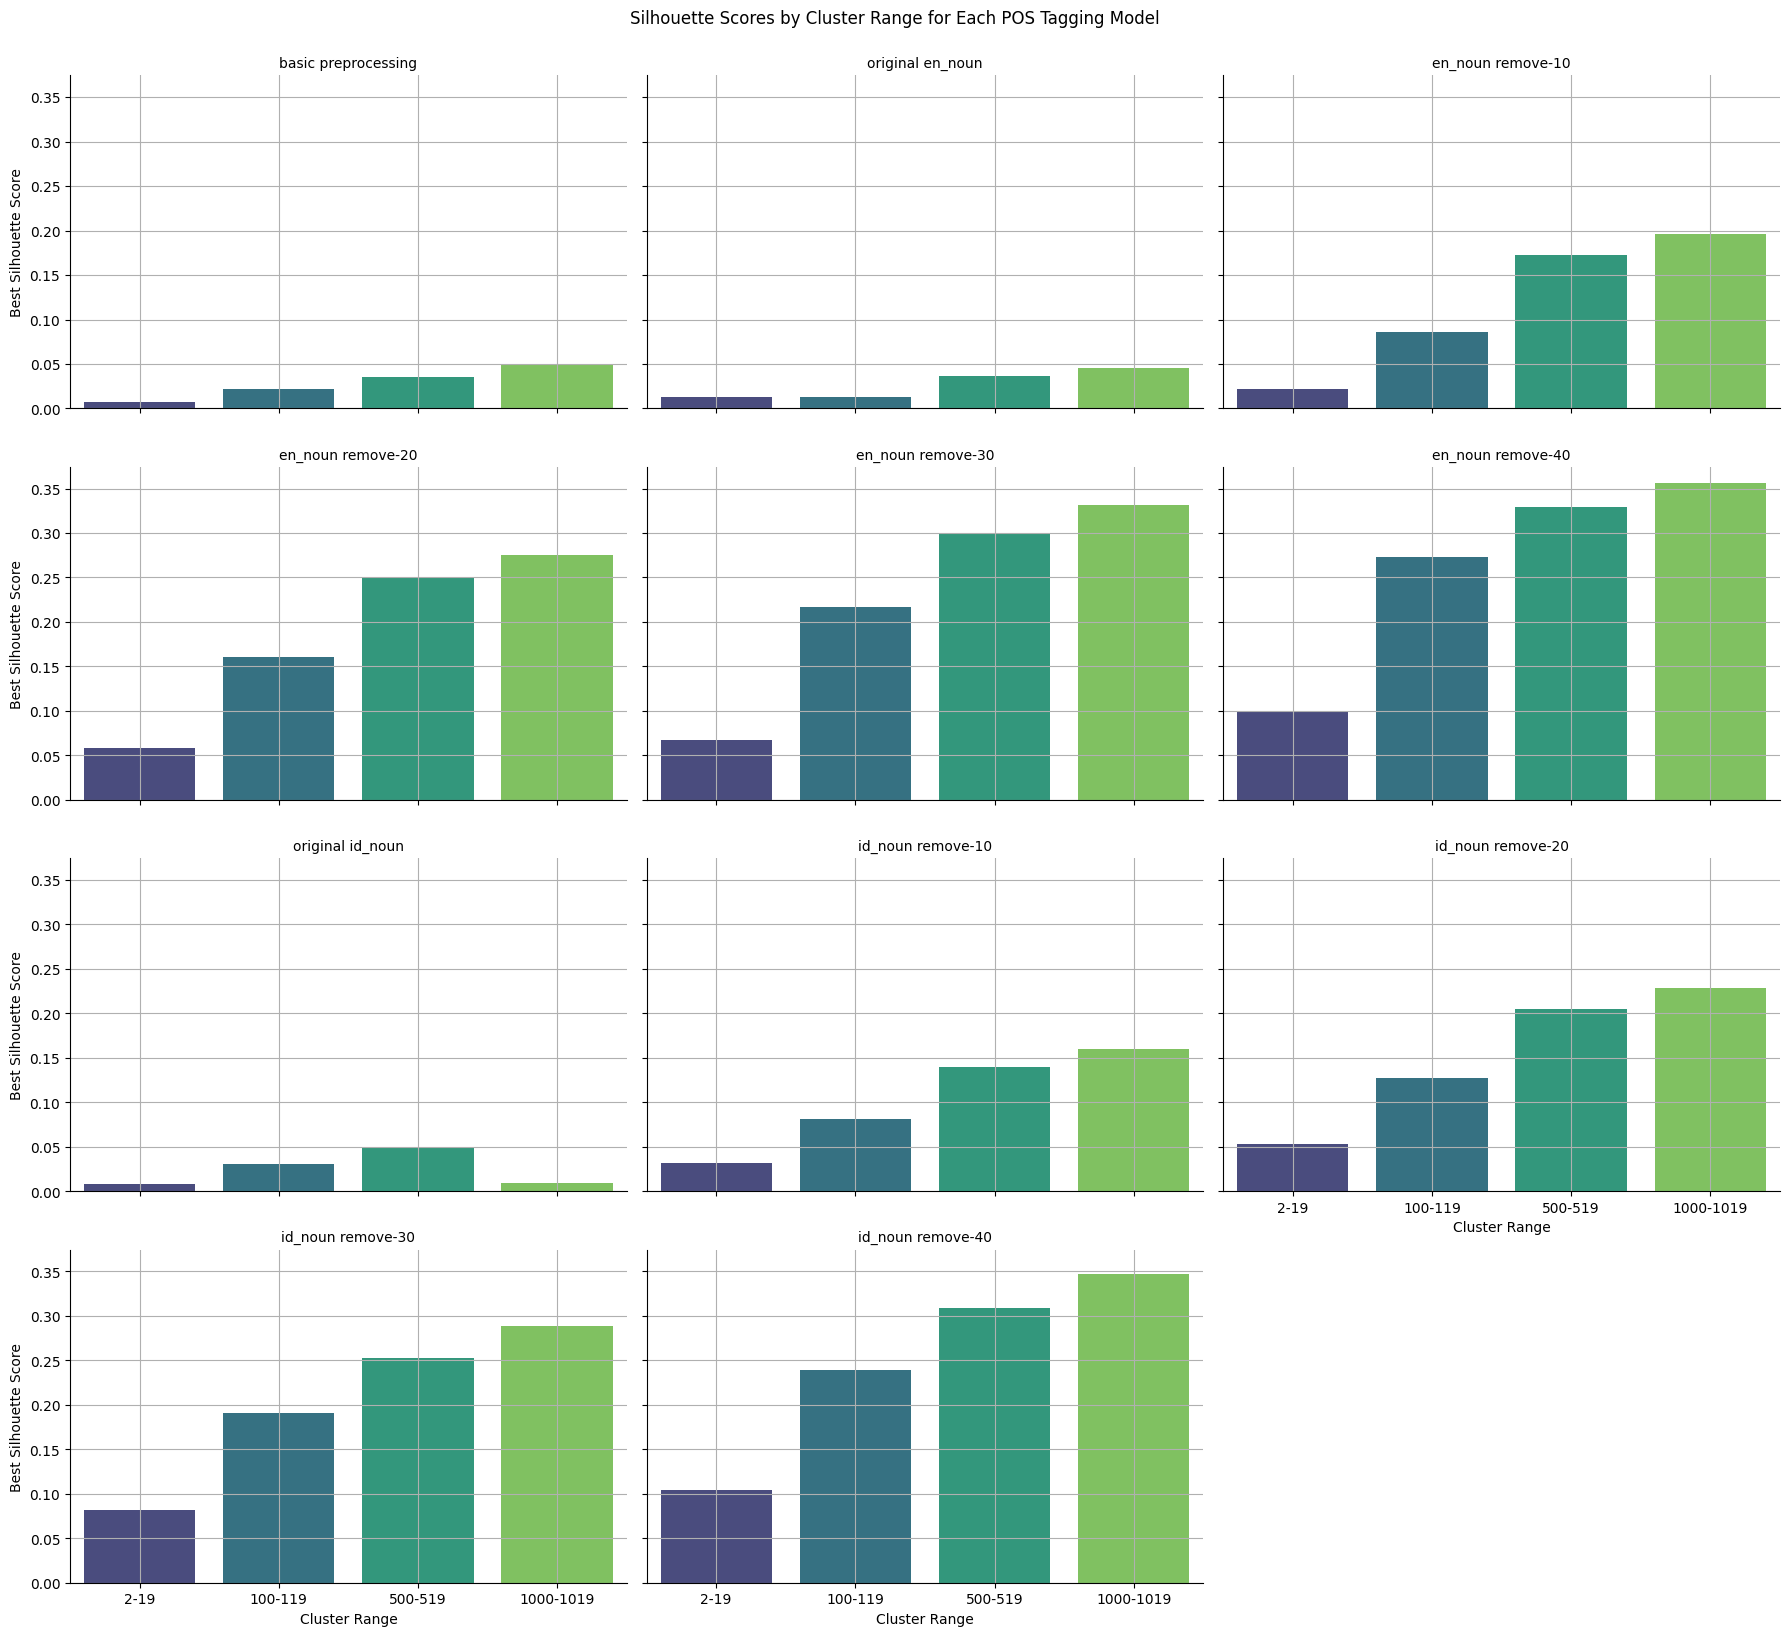

In [11]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

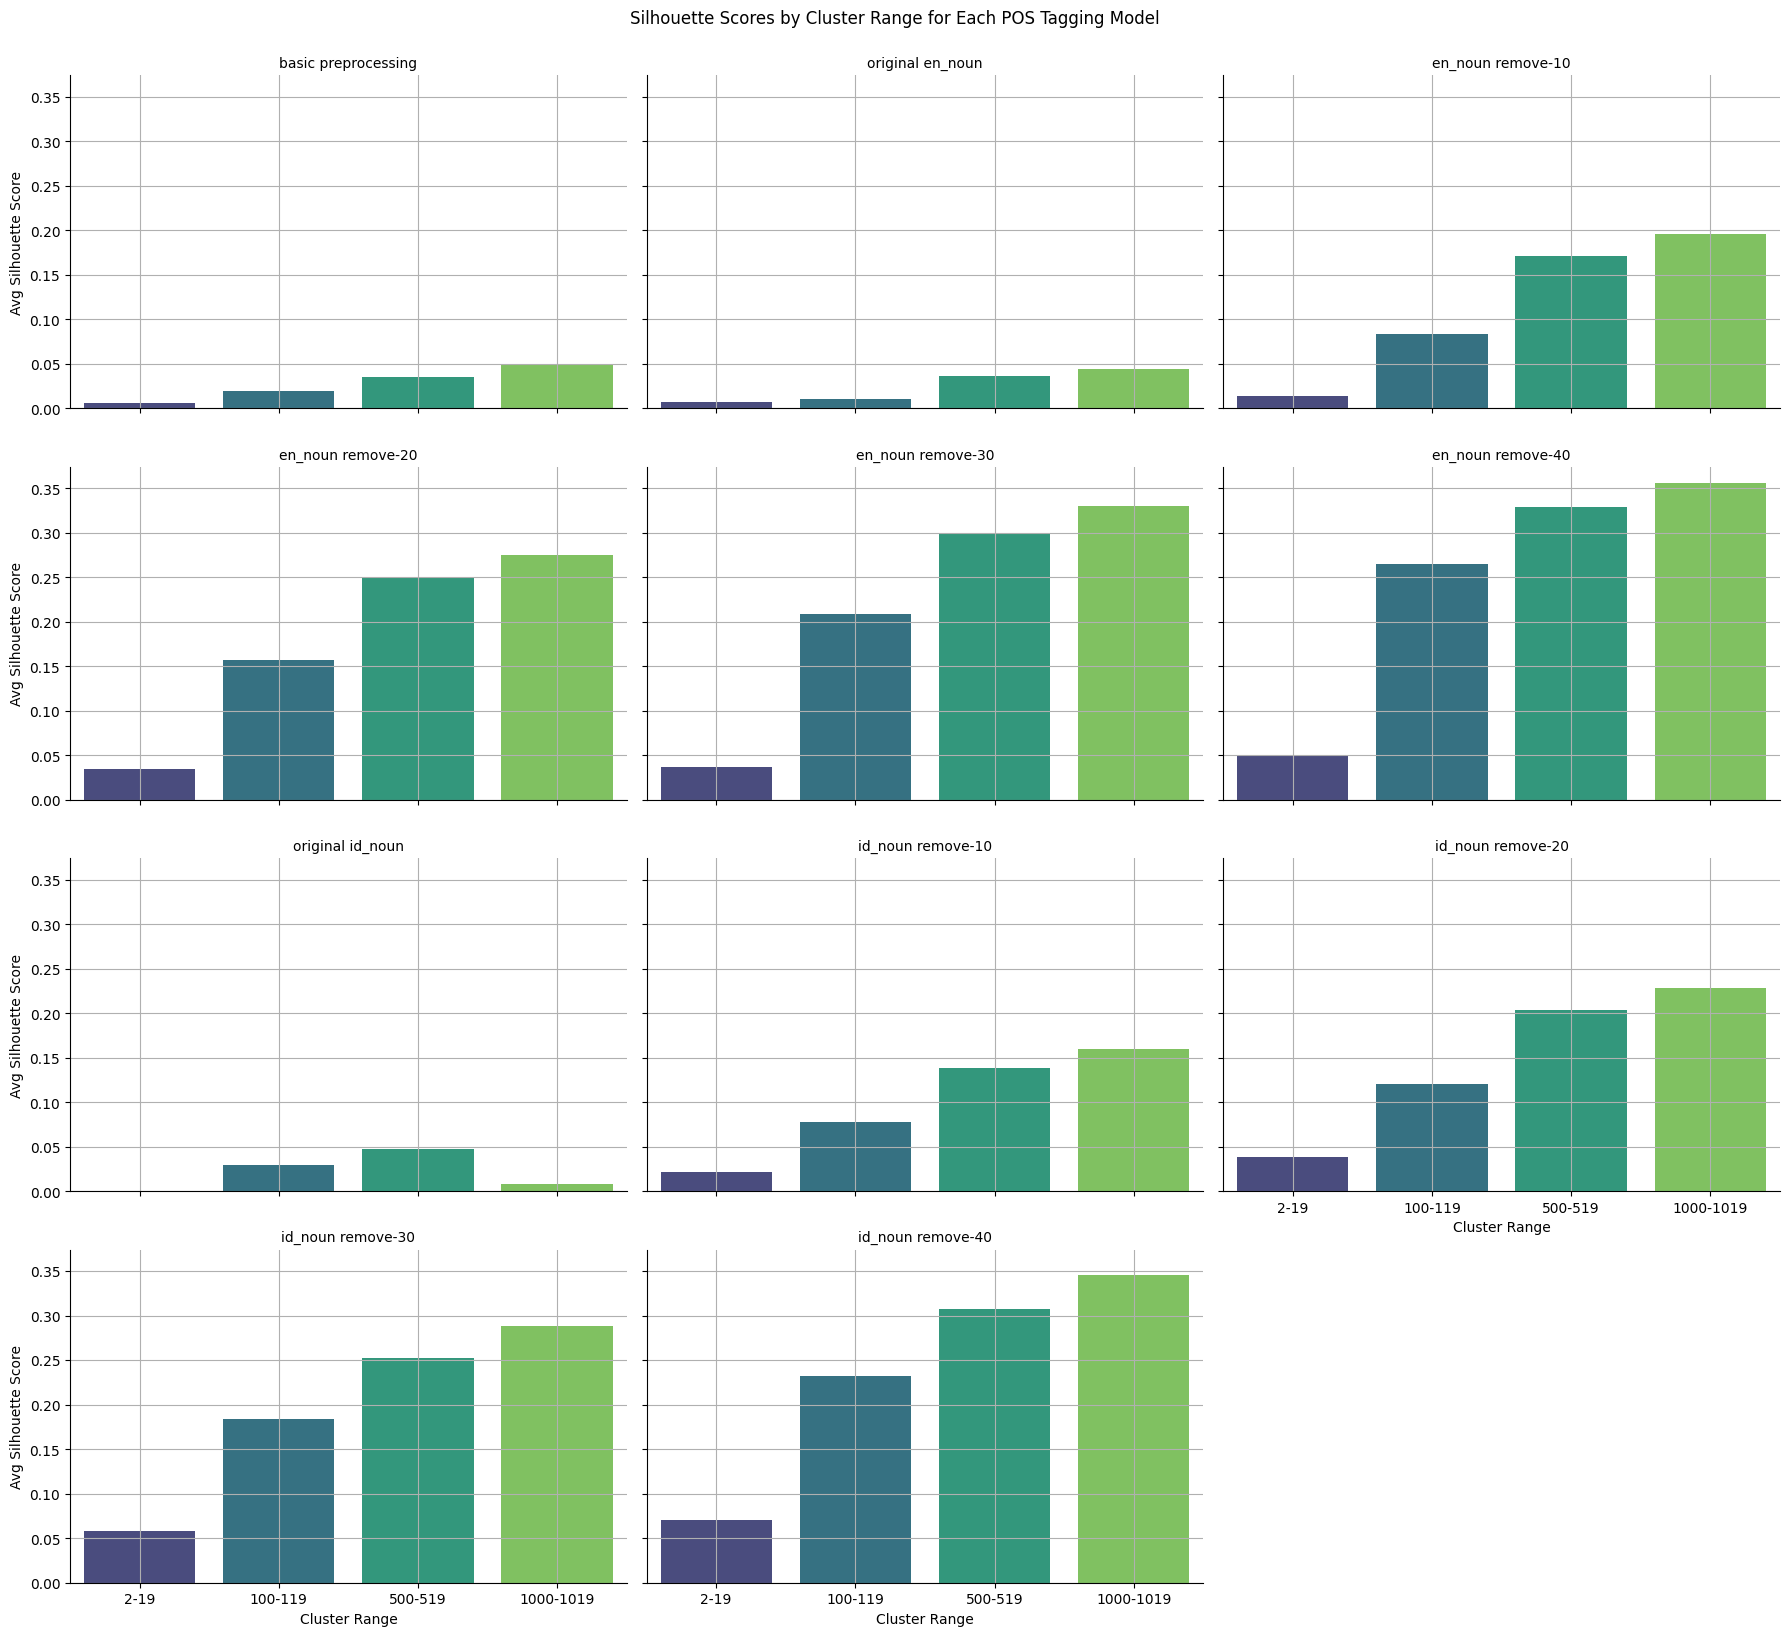

In [12]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# CLEAN VERSION

In [11]:
df1 = pd.read_csv('data/clean/clean_dataset_posBERTV1-1.csv')
df1.head()

name  \
0   Gamis Pria Dewasa Premium / Jubah Pakistan Polos   
1  Buket Bunga Mawar Flanel / Bunga wisuda / Bung...   
2  Mika Sen Depan Supra Fit New Kaca Lampu Sein D...   
3  Blazer wanita jumbo big size stik balik / plus...   
4  Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...   

                                    multiCorpus_noun  name_length  \
0                                pria jubah pakistan            4   
1  buket bunga mawar flanel bunga wisuda bunga so...           17   
2          mika depan fit kaca lampu dpn motor bebek           16   
3                           blazer wanita jumbo plus           12   
4                  buku ilmu sosial budaya kesadaran            4   

                           multiCorpus_noun_rm10       multiCorpus_noun_rm20  \
0                                           pria                        pria   
1  buket bunga mawar bunga wisuda bunga souvenir  bunga bunga bunga souvenir   
2                mika fit kaca lampu motor bebek  fit kaca lampu motor bebek   
3                            blazer wanita jumbo         blazer wanita jumbo   
4                               buku ilmu sosial                        buku   

  multiCorpus_noun_rm30 multiCorpus_noun_rm40  
0                  pria                  pria  
1     bunga bunga bunga     bunga bunga bunga  
2      kaca lampu motor      kaca lampu motor  
3          wanita jumbo          wanita jumbo  
4                  buku                  buku

In [16]:
# List min_df dan range klaster
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
vectorizers = {
    'original noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun']),
    'noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm10']),
    'noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm20']),
    'noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm30']),
    'noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm40'])
}
results1 = []  # List untuk menyimpan hasil eksperimen

In [17]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(range_list, results):

    for name, data in vectorizers.items():
        for cluster_range in range_list:
            silhouette_scores = []
            for n_clusters in cluster_range:
                # K-Means clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # Simpan hasil eksperimen
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# Jalankan eksperimen
clustering_experiment(range_list, results1)

In [18]:
results_df1 = pd.DataFrame(results1)

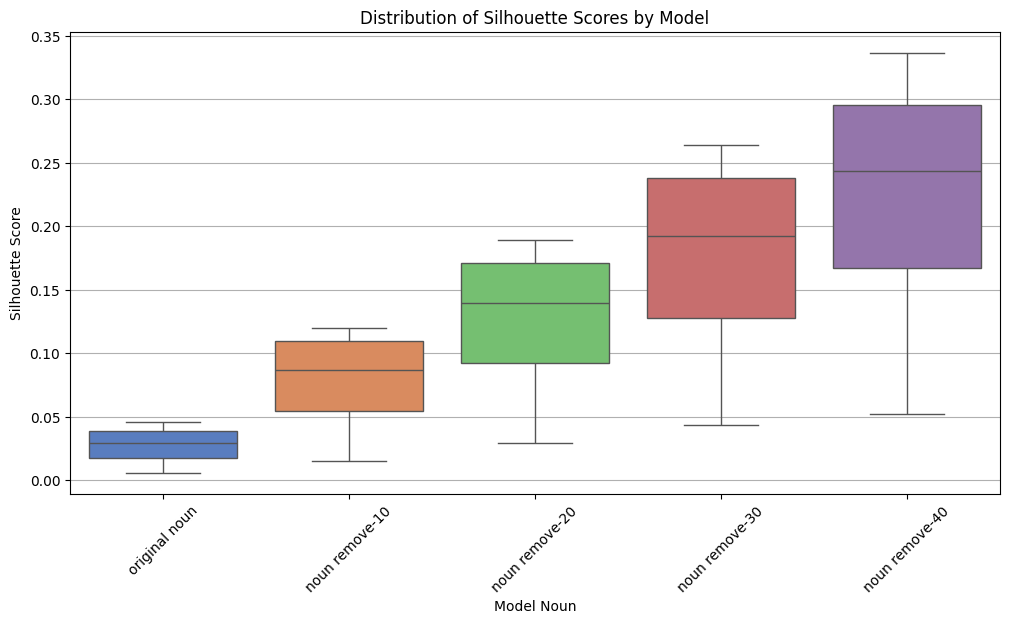

In [20]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df1,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='model_noun'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


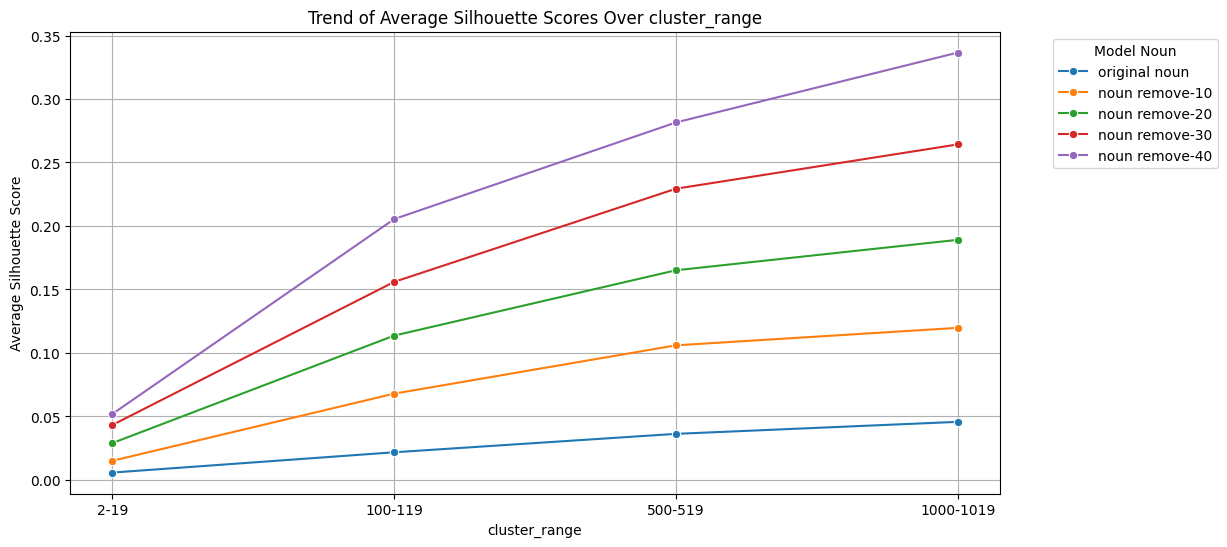

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df1,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


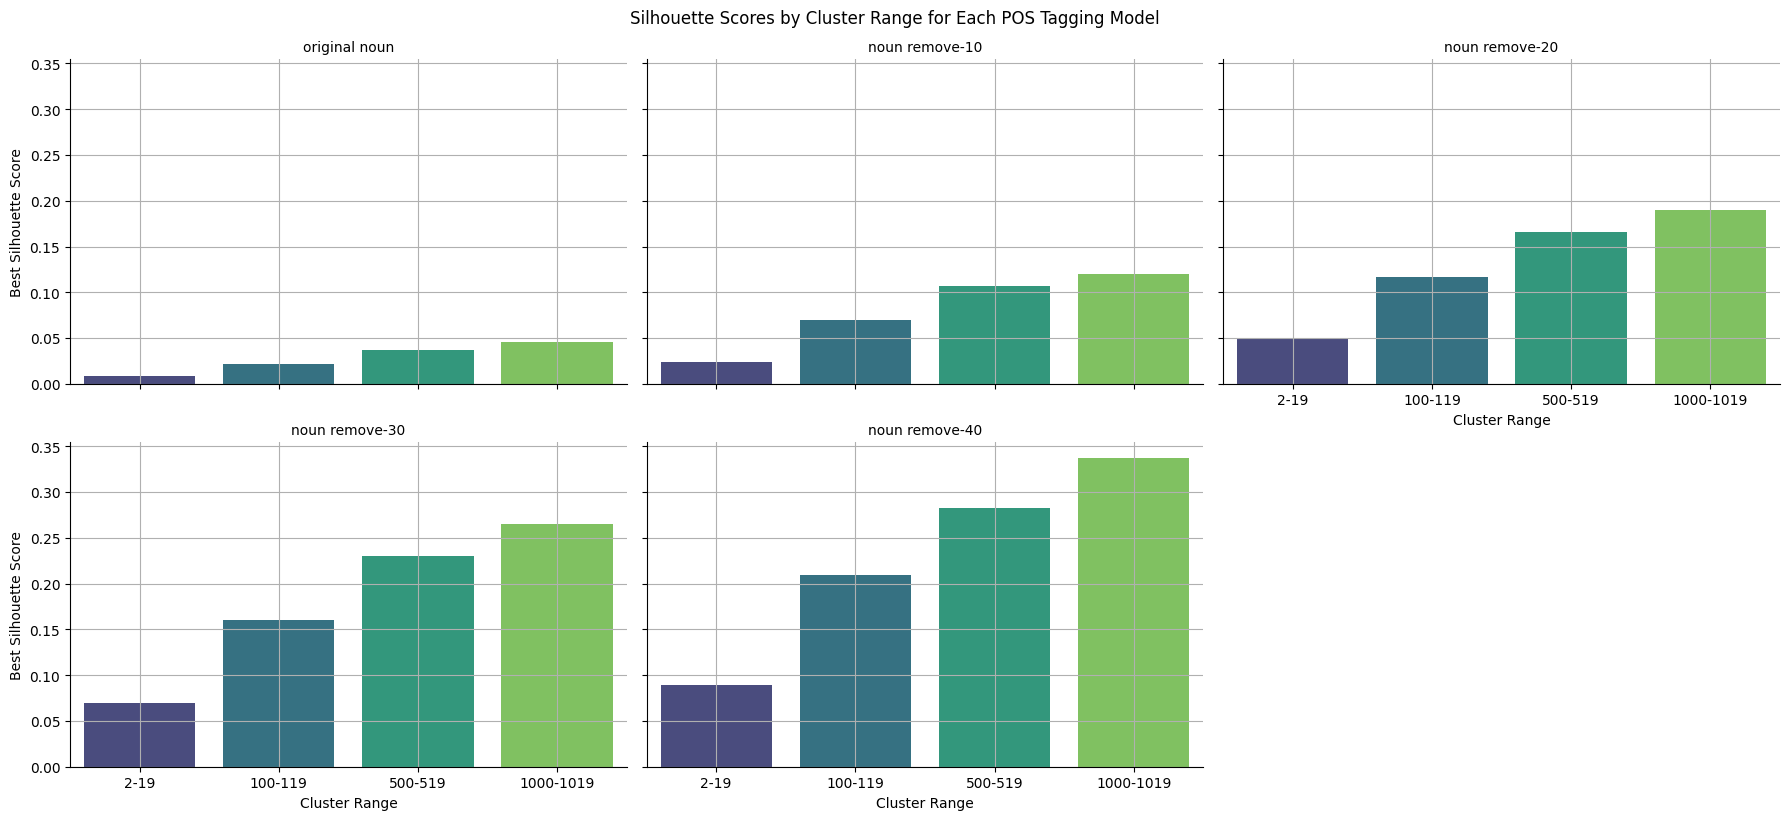

In [23]:
g = sns.FacetGrid(
    results_df1,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue
                ="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

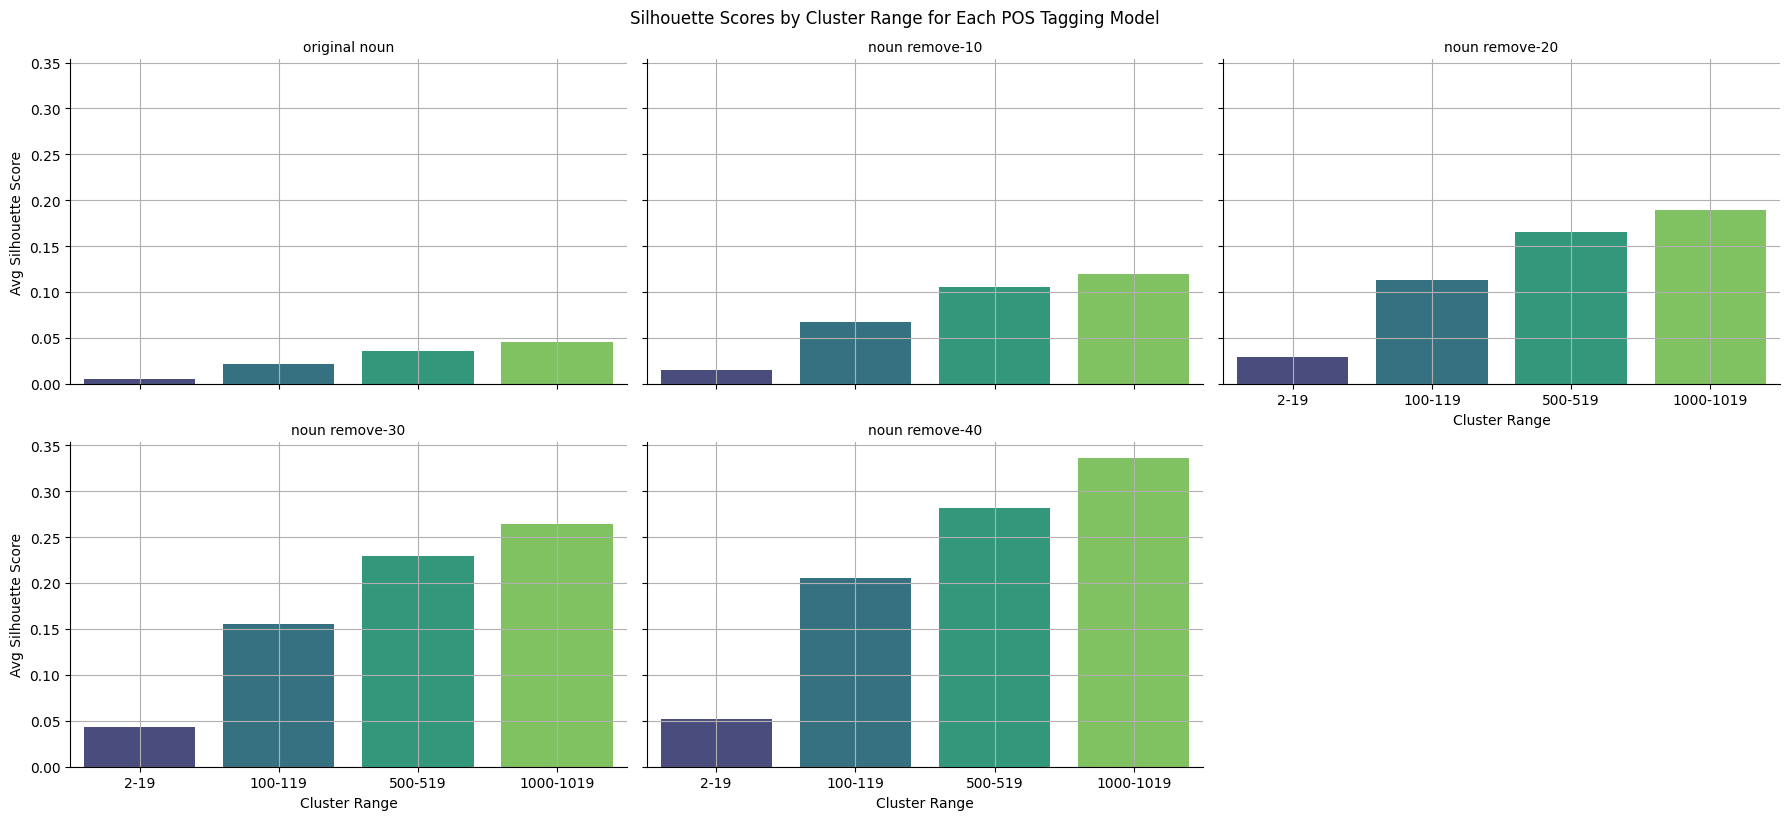

In [24]:
g = sns.FacetGrid(
    results_df1,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# BEST MODEL IS EN_NOUN_RM40

In [17]:
def show_cluster(column_name, cluster_number):
    pd.set_option('display.max_colwidth', None)

    # Show some product examples from each cluster
    for n_clusters in range(cluster_number):
        print(f"\nExamples of products in Cluster {n_clusters}:")
        print(df[df[column_name] == n_clusters][['name']].head(5))

    # Reset display option
    pd.reset_option('display.max_colwidth')

In [18]:
from wordcloud import WordCloud

def show_wordclouds(column_name, cluster_number):
    for n_clusters in range(cluster_number):
        # Ambil teks dari cluster tertentu
        cluster_data = df[df[column_name] == n_clusters]['name'].dropna().tolist()
        text = " ".join(cluster_data)  # Gabungkan semua teks dalam cluster

        # Buat WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Tampilkan WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {n_clusters}", fontsize=16)
        plt.show()

## Find Optimum K Cluster

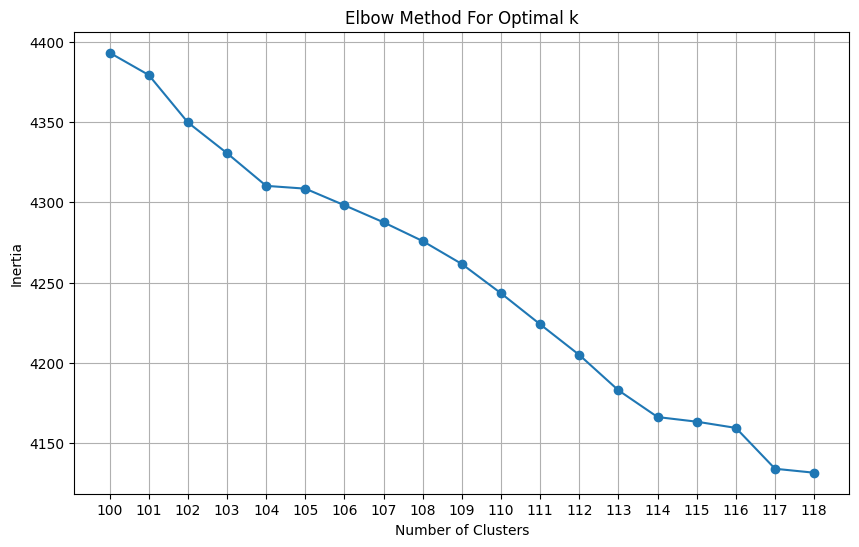

In [19]:
inertia_values = []
cluster_range = range(100, 119)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['en_noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

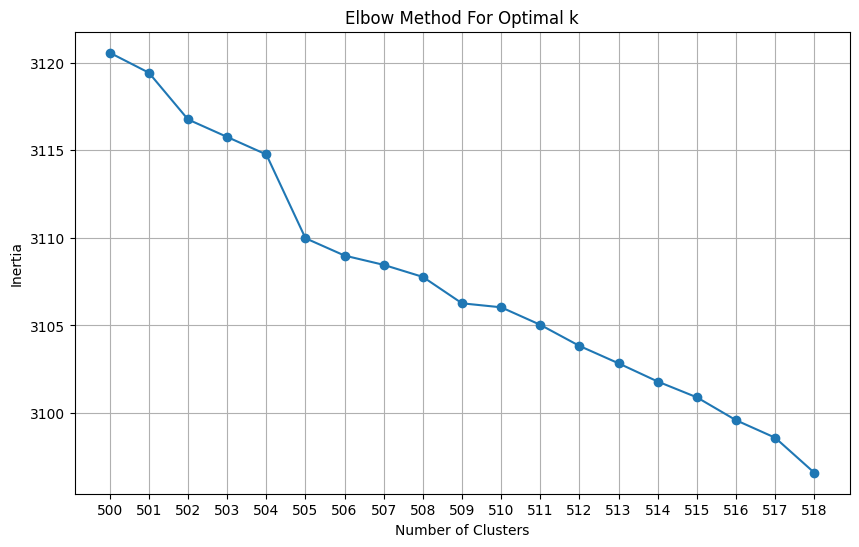

In [20]:
inertia_values = []
cluster_range = range(500, 519)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['en_noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

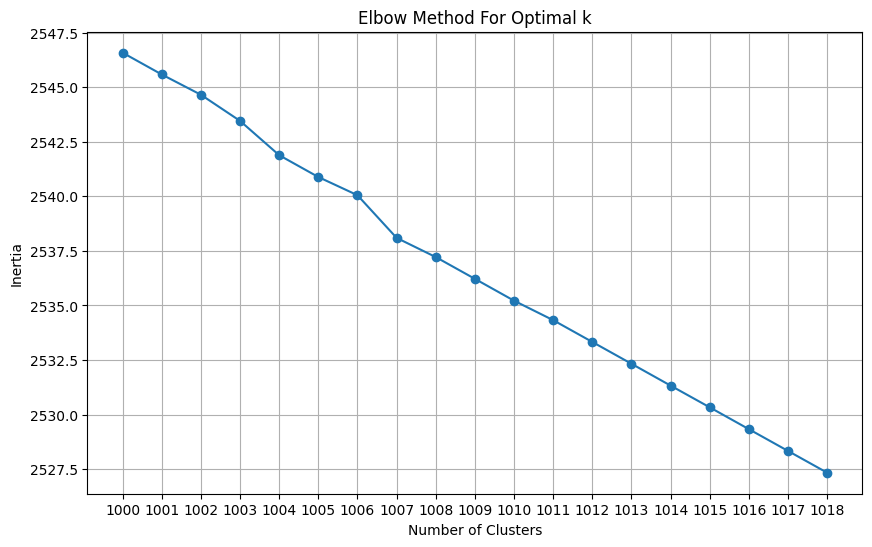

In [21]:
inertia_values = []
cluster_range = range(1000, 1019)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['en_noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## Analysis Each Optimum Cluster

### Cluster 100

In [22]:
optimal_k = 104
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster100'] = kmeans.fit_predict(vectorizers['en_noun remove-40'])

In [23]:
show_cluster('cluster100', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap

Examples of products in Cluster 1:
                                                                        name
1256  Cede Kenari 50gr Cede Eggfood Canaries Premium Makanan Burung Tambahan
3257           QUINOA RED ORGANIC PREMIUM 500gr | QUINOA MERAH ORGANIK 500gr
5094     100gr Cabe Rawit Bubuk / Ground Cayanne / Rempah / JSR 100% PREMIUM
6115      SEI SAPI PREMIUM / SEI SAPI ASAP 150gr + Aneka rasa pilihan sambal
6147     Cumi Asin Telor Telur Asin Kering Super Premium Grade A 500gr Promo

Examples of products in Cluster 2:
                                                                    name
5695  Buku standar bahasa korea EPS TOPIK untuk orang indonesia (2 buku)

Examples of products in Cluster 3:
                                                                        name
3479  Koil Coil BRT

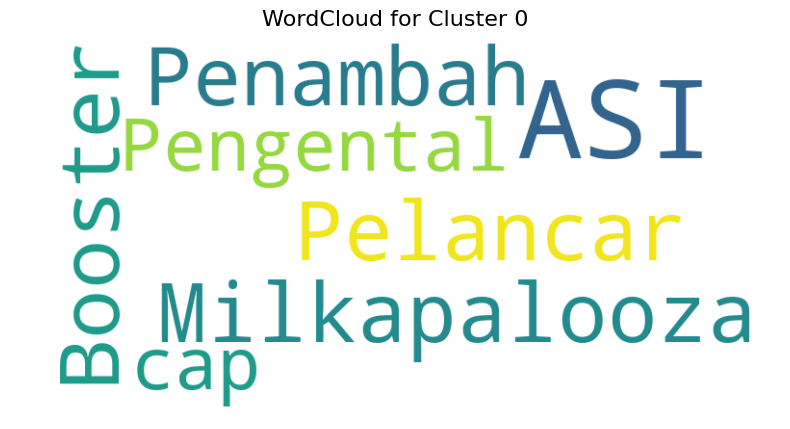

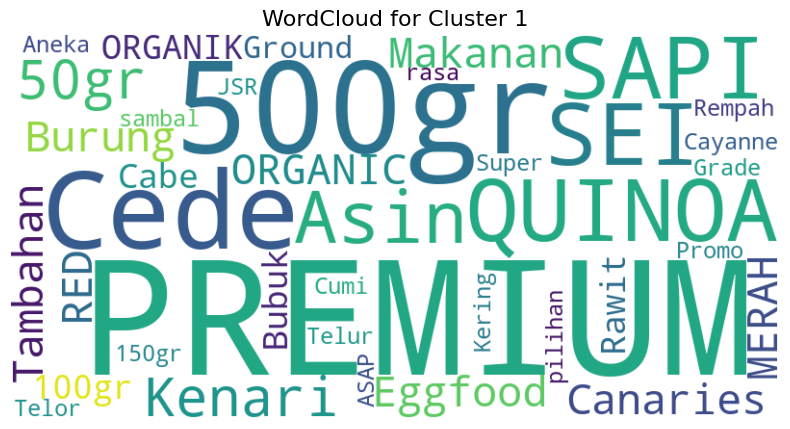

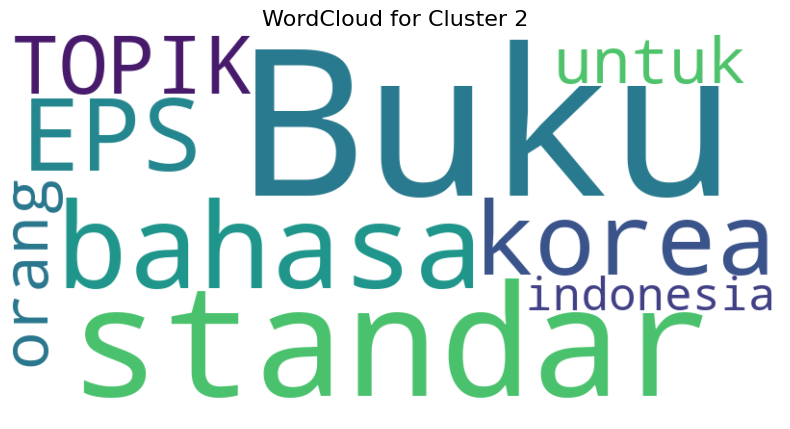

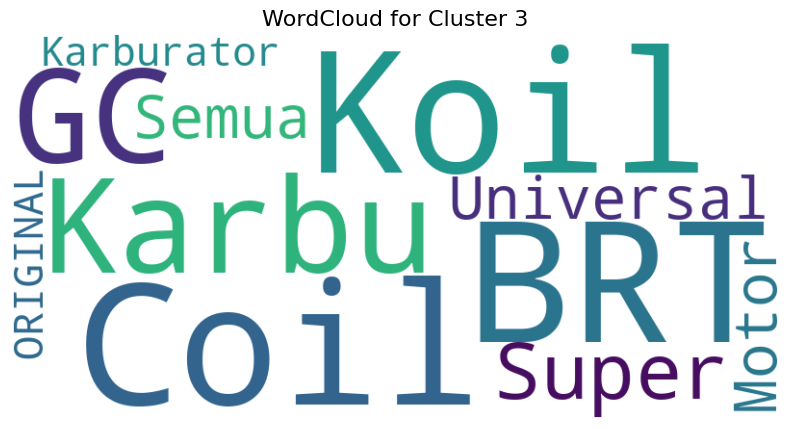

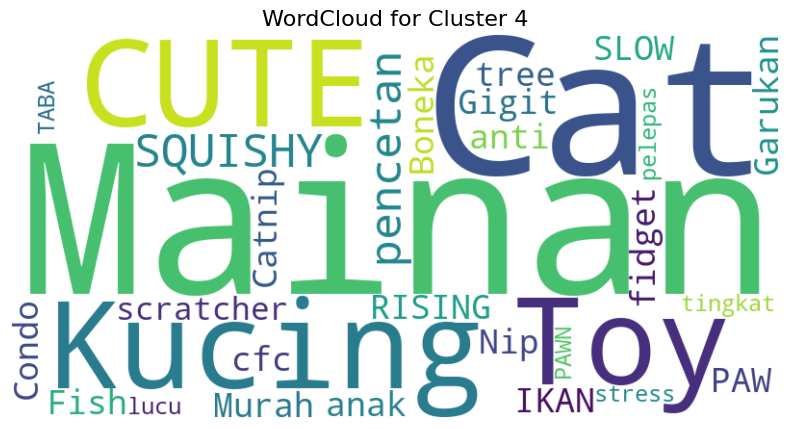

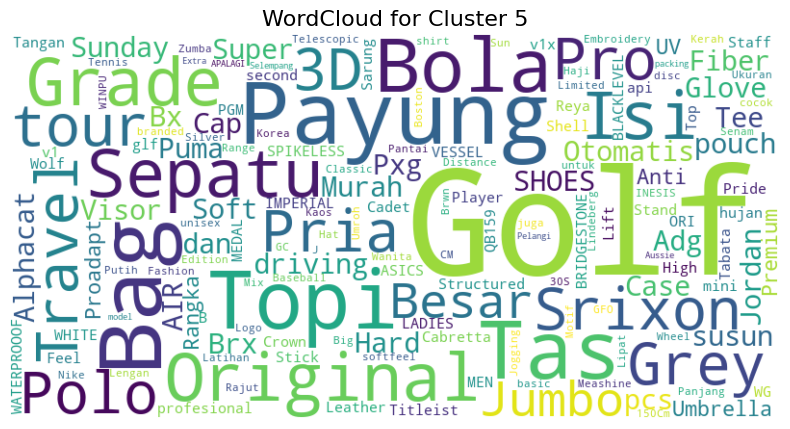

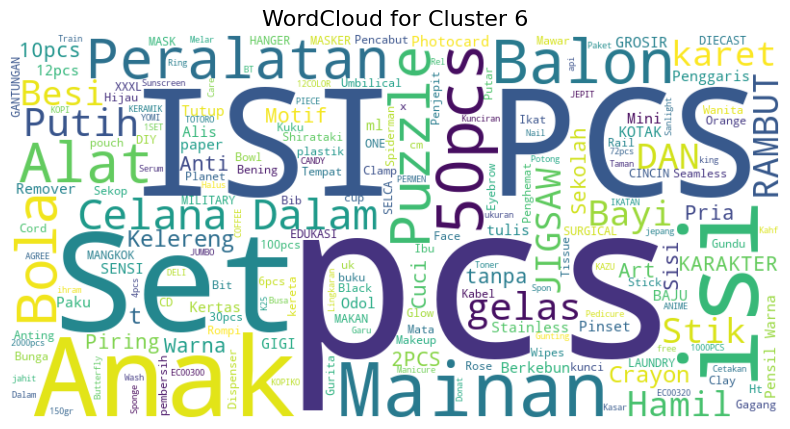

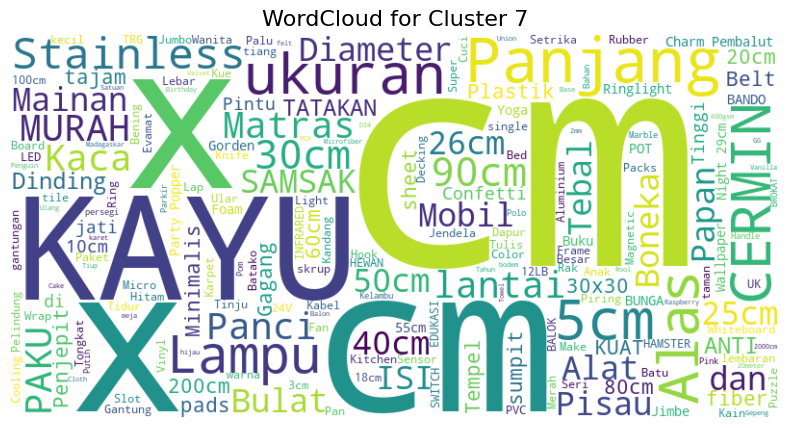

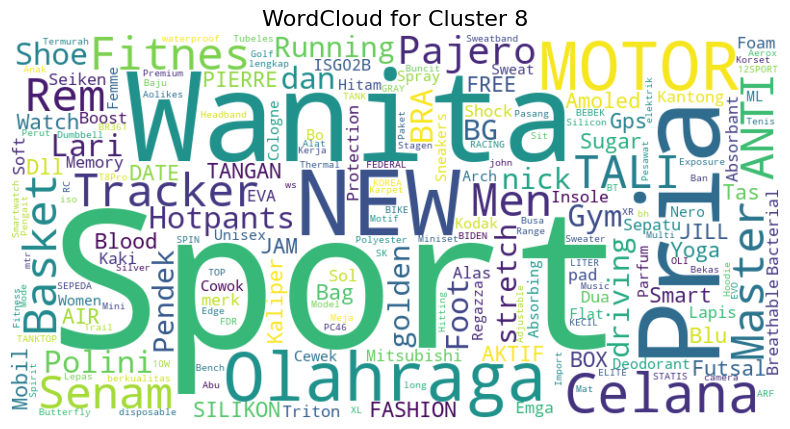

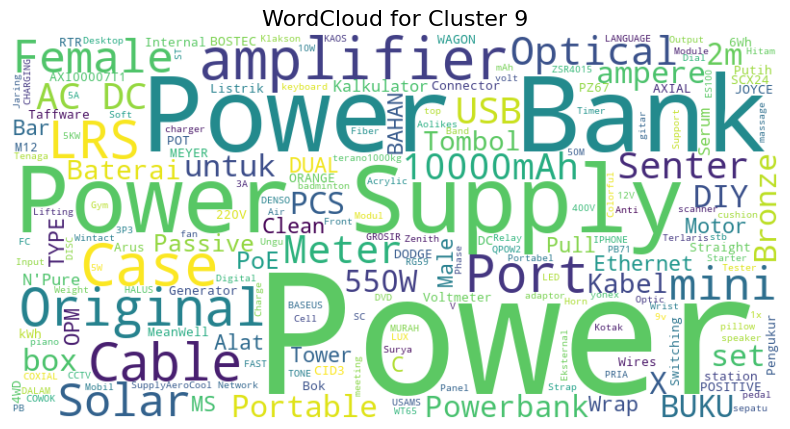

In [24]:
show_wordclouds('cluster100', 10)

### Cluster 500

In [25]:
optimal_k = 505
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster500'] = kmeans.fit_predict(vectorizers['en_noun remove-40'])

In [26]:
show_cluster('cluster500', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap

Examples of products in Cluster 1:
                                                                        name
1256  Cede Kenari 50gr Cede Eggfood Canaries Premium Makanan Burung Tambahan
3257           QUINOA RED ORGANIC PREMIUM 500gr | QUINOA MERAH ORGANIK 500gr
5094     100gr Cabe Rawit Bubuk / Ground Cayanne / Rempah / JSR 100% PREMIUM
6115      SEI SAPI PREMIUM / SEI SAPI ASAP 150gr + Aneka rasa pilihan sambal
6147     Cumi Asin Telor Telur Asin Kering Super Premium Grade A 500gr Promo

Examples of products in Cluster 2:
                                                                    name
5695  Buku standar bahasa korea EPS TOPIK untuk orang indonesia (2 buku)

Examples of products in Cluster 3:
                                                                        name
3479  Koil Coil BRT

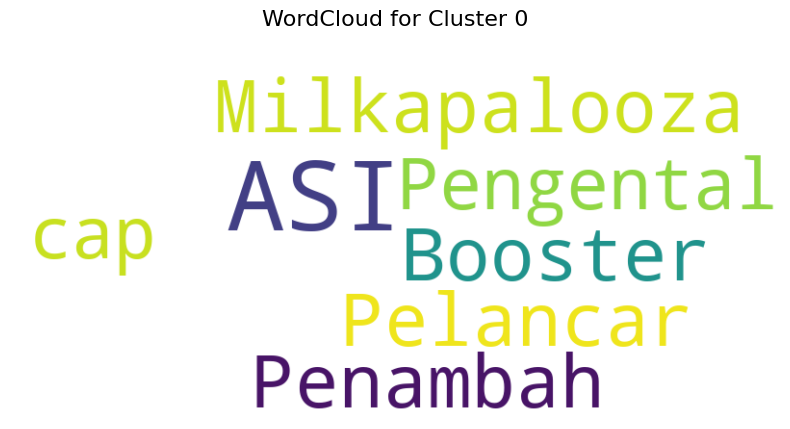

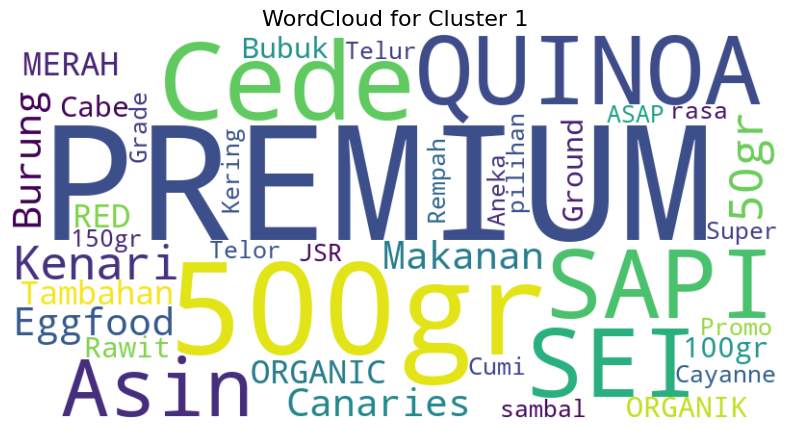

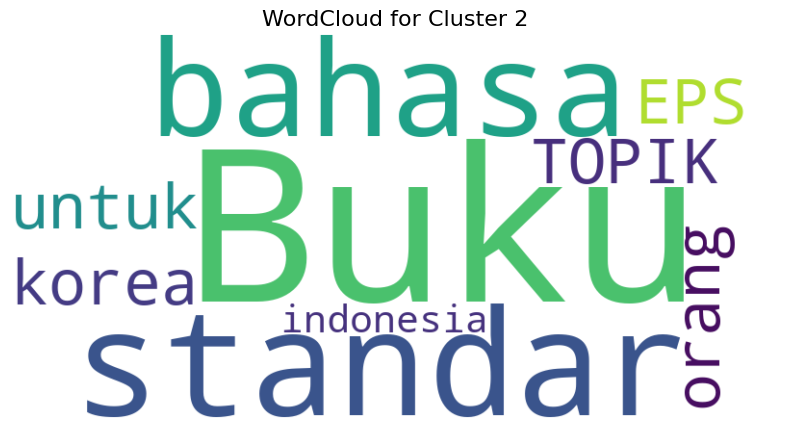

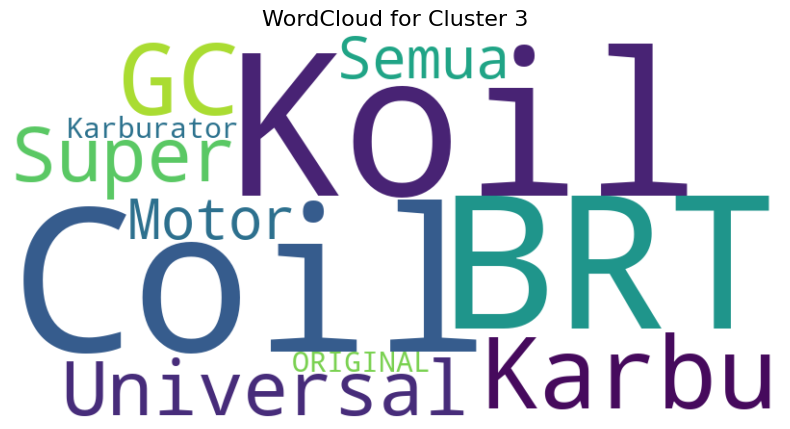

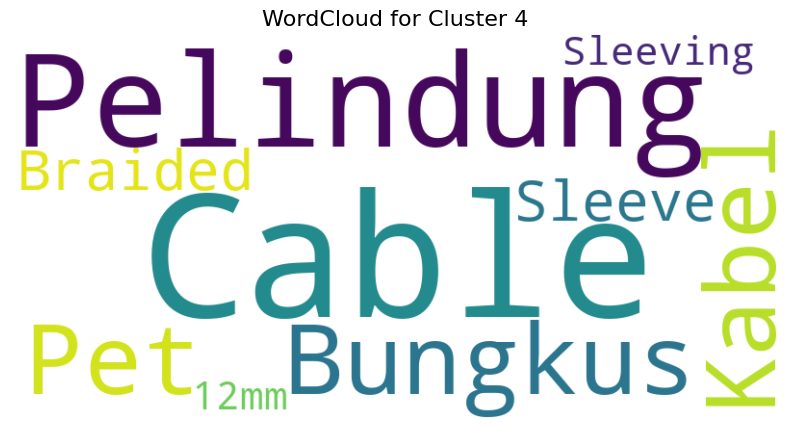

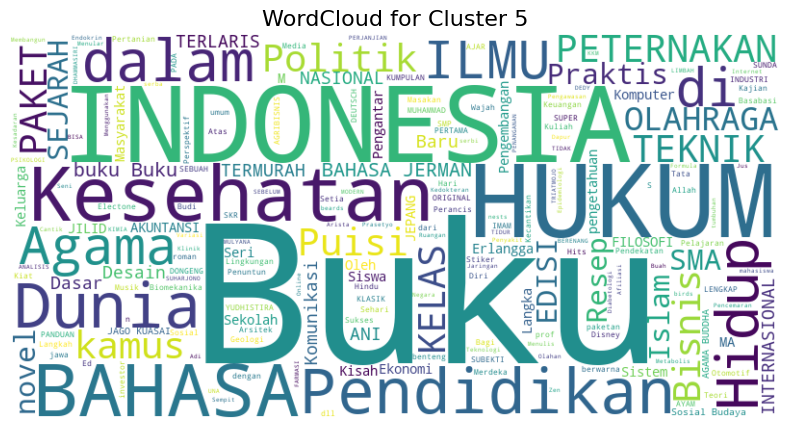

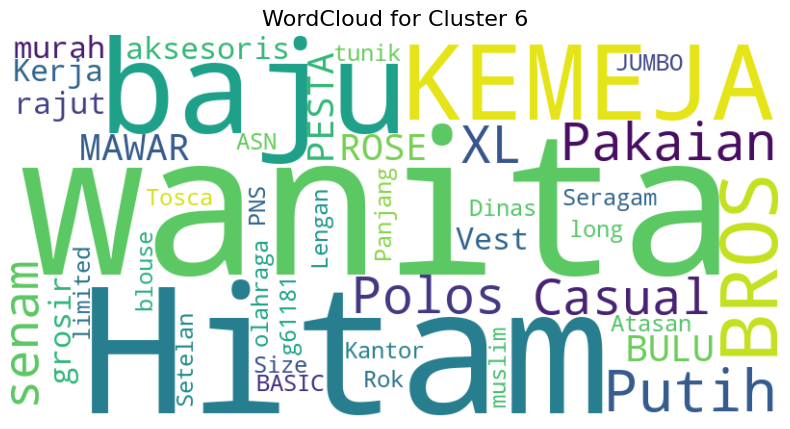

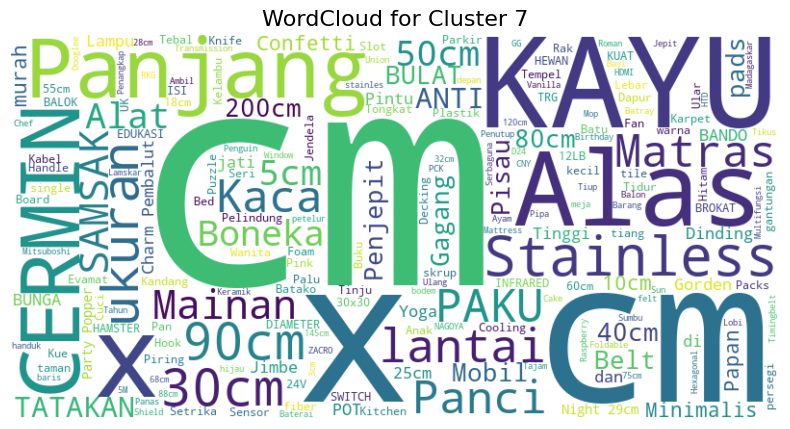

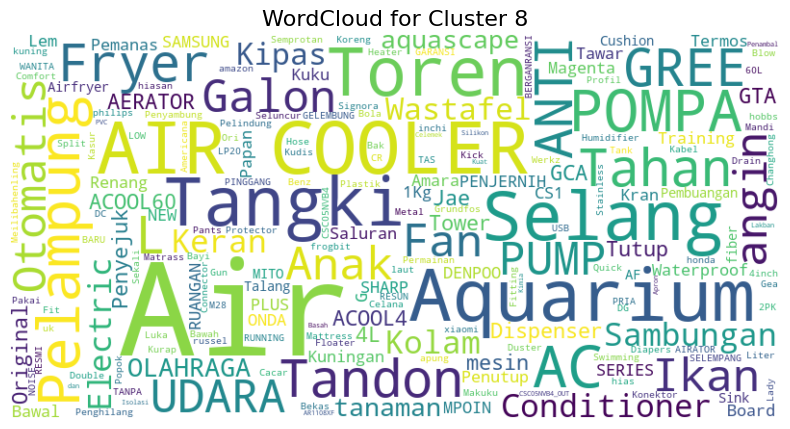

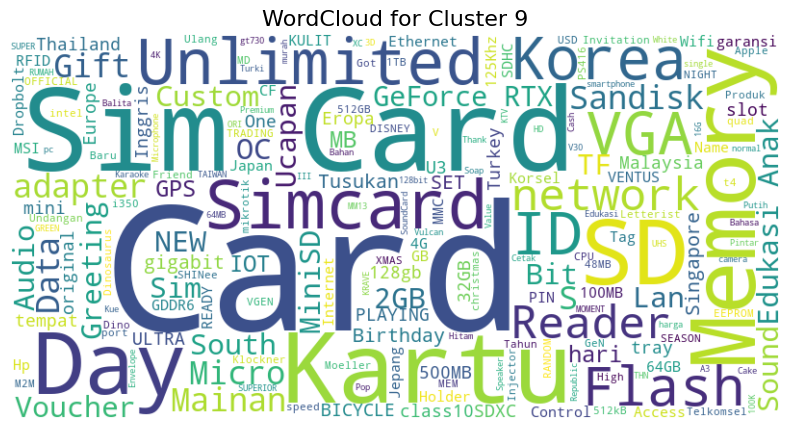

In [27]:
show_wordclouds('cluster500', 10)

### Cluster 1000

In [28]:
optimal_k = 1007
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster1000'] = kmeans.fit_predict(vectorizers['en_noun remove-40'])

In [29]:
show_cluster('cluster1000', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap

Examples of products in Cluster 1:
                                                                        name
1256  Cede Kenari 50gr Cede Eggfood Canaries Premium Makanan Burung Tambahan
3257           QUINOA RED ORGANIC PREMIUM 500gr | QUINOA MERAH ORGANIK 500gr
5094     100gr Cabe Rawit Bubuk / Ground Cayanne / Rempah / JSR 100% PREMIUM
6115      SEI SAPI PREMIUM / SEI SAPI ASAP 150gr + Aneka rasa pilihan sambal
6147     Cumi Asin Telor Telur Asin Kering Super Premium Grade A 500gr Promo

Examples of products in Cluster 2:
                                                                    name
5695  Buku standar bahasa korea EPS TOPIK untuk orang indonesia (2 buku)

Examples of products in Cluster 3:
                                                                        name
3479  Koil Coil BRT

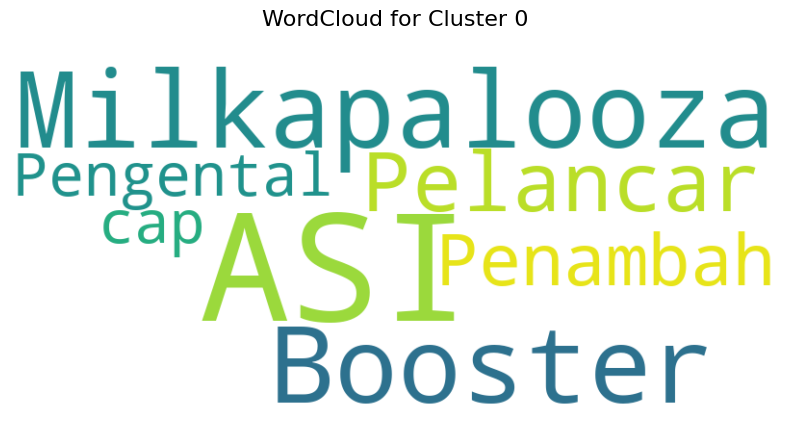

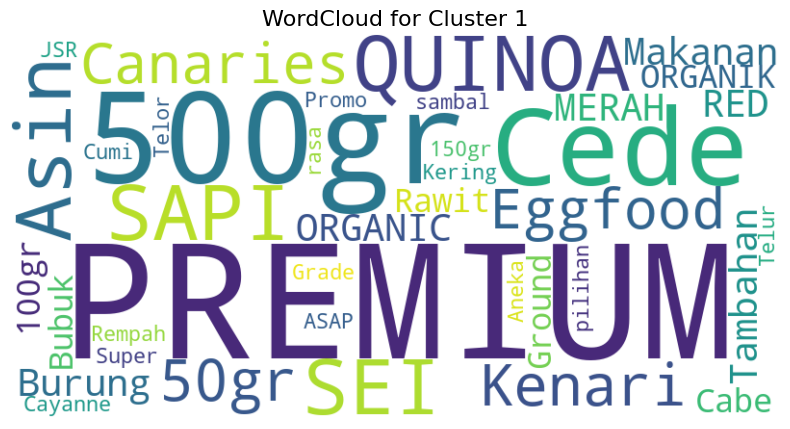

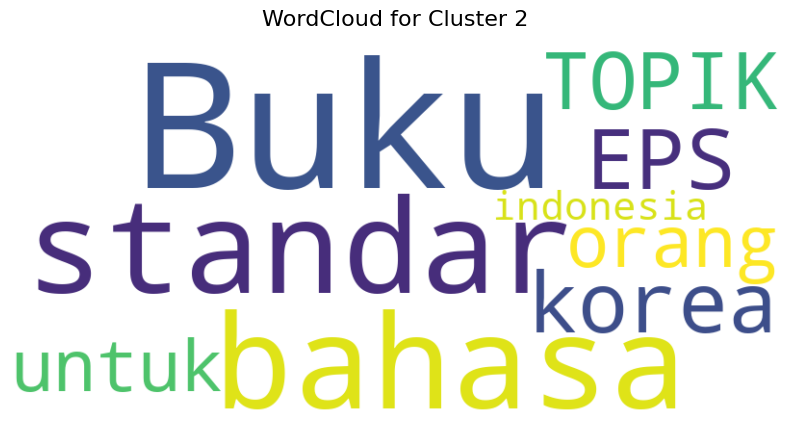

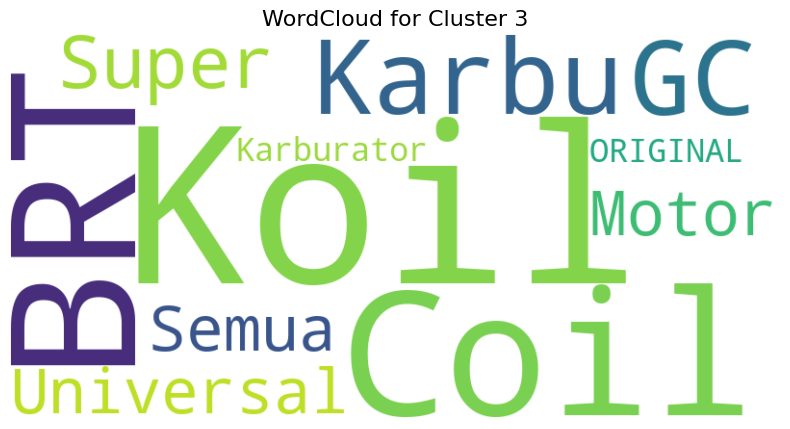

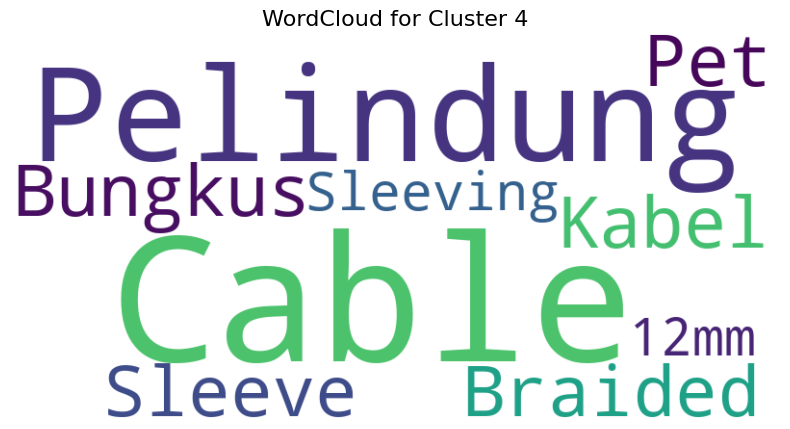

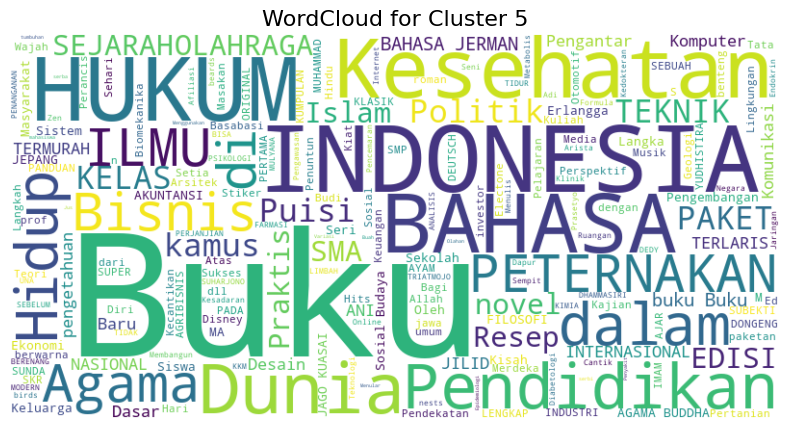

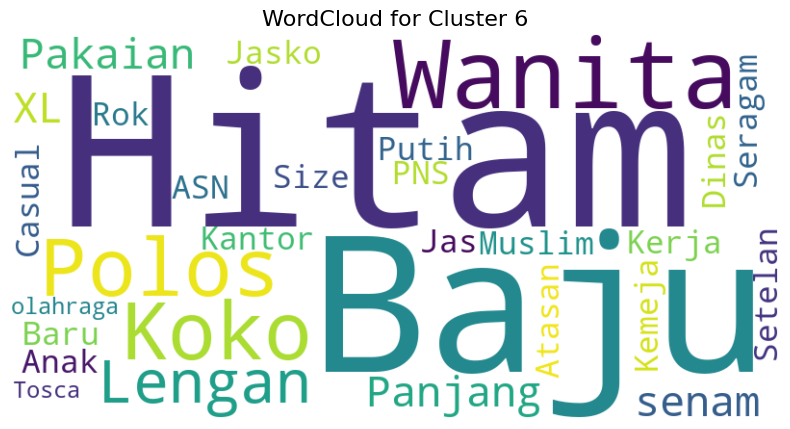

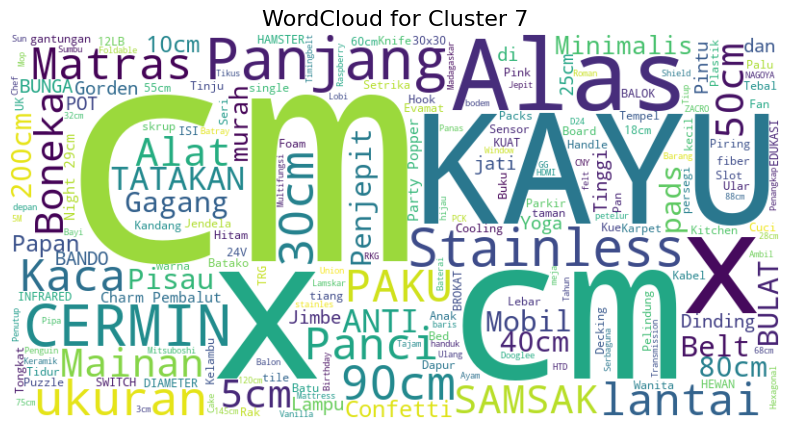

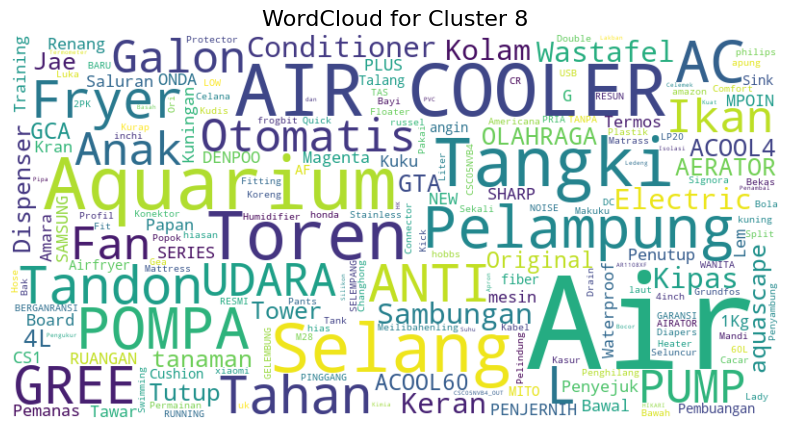

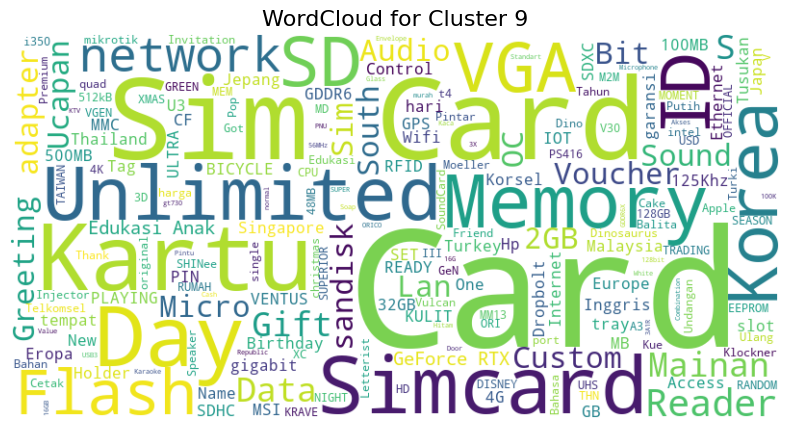

In [30]:
show_wordclouds('cluster1000', 10)